In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/branch'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset, SequentialMIONetDataset
from helper import  convert2dim, train_val_test_split, fit, compute_metrics_region

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Models

In [3]:
from branch_analysis import load_model_experiment

In [4]:
#------------------------------
# Load single branch model
#------------------------------
model_path = 'single_branch/lstm_window_30.pth'

s_model = load_model_experiment("single", model_path).to(device)

Loaded model from single_branch/lstm_window_30.pth


In [5]:
#------------------------------
# Load multi branch model
#------------------------------
model_path = 'multi_branch/lstm_window_30.pth'

m_model = load_model_experiment("multi", model_path).to(device)

Loaded model from multi_branch/lstm_window_30.pth


## Load Datasets

In [6]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
input_sensor = np.load('data/neutron_data_22yrs.npy')

# 1 degree target
output_1deg = np.load('data/dose_array.npy')


# data splitting keeping the consistency with training phase
train_input_1, train_target_1, val_input_1, val_target_1, test_input_1, test_target_1 = train_val_test_split(input_sensor, output_1deg)


# input scaler
scaler = MinMaxScaler()

# the input data is common for both 1 deg and 0.25 deg targets
# so we fit the scaler only once using train_input_1
dummy = scaler.fit_transform(train_input_1)
test_input_1 = scaler.transform(test_input_1)


# target data normalization (min-max scaling)
scaler_target_1 = MinMaxScaler()
train_target_1 = scaler_target_1.fit_transform(train_target_1)[..., np.newaxis]
test_target_1 = scaler_target_1.transform(test_target_1)[..., np.newaxis]


# location points for 1 degree target
trunk_1deg = np.load('data/grid_points.npy')

print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))

# Normalize trunk input
trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))


# Generate sequences for the testing set
test_input_seq_1, test_target_seq_1 = create_sliding_windows(test_input_1, test_target_1, window_size=30)

print('test_input_seq shape:', test_input_seq_1.shape)
print('test_target_seq shape:', test_target_seq_1.shape)

Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)
location range (1 deg): -90.0 90.0 -180.0 180.0
test_input_seq shape: torch.Size([336, 30, 12])
test_target_seq shape: torch.Size([336, 65341, 1])


In [7]:
s_test_dataset =  SequentialDeepONetDataset(test_input_seq_1, trunk_1deg, test_target_seq_1)
m_test_dataset =  SequentialMIONetDataset(test_input_seq_1, trunk_1deg, test_target_seq_1)

s_test_loader = DataLoader(s_test_dataset, batch_size=32, shuffle=False)
m_test_loader = DataLoader(m_test_dataset, batch_size=32, shuffle=False)

Mean feature-feature correlation (single-branch):        0.798
Mean feature-feature correlation (multi-branch pre):     0.201
Mean feature-feature correlation (multi-branch post):    0.761
Mean inter-sensor correlation (multi-branch pre-fusion): 0.096


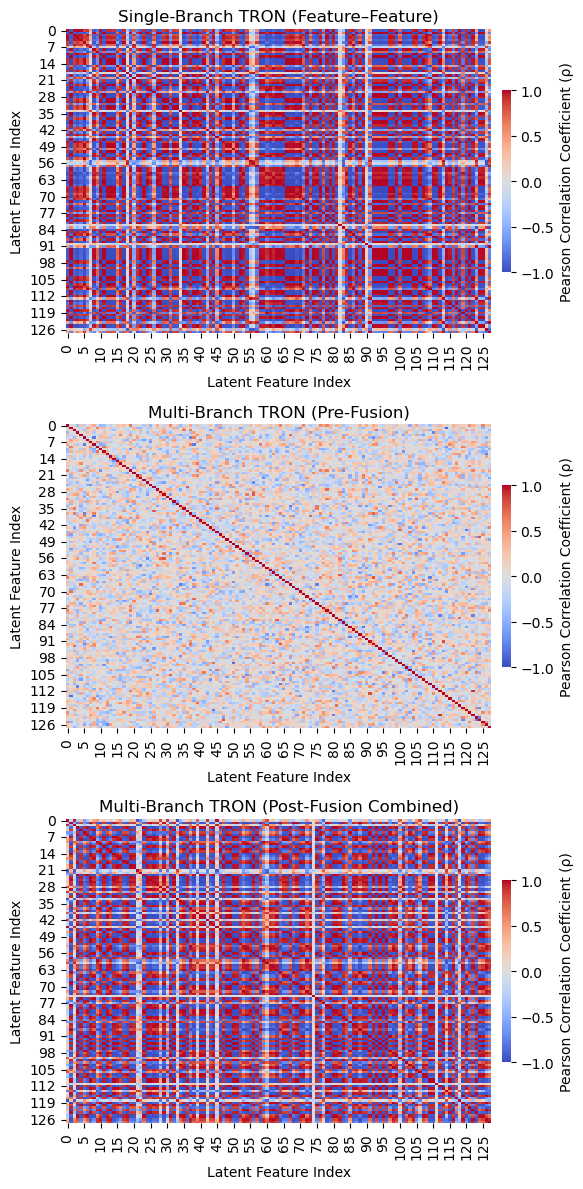

In [8]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# 1. LATENT EXTRACTION FUNCTIONS
# ============================================================

def extract_latent_single(model, seq_batch):
    """Extract final latent representation from single-branch TRON."""
    model.eval()
    with torch.no_grad():
        _, (h_n, _) = model.branch_net.lstm(seq_batch)
        latent = h_n[-1]
        latent = model.branch_net.layer_norm(latent)
        latent = model.branch_net.fc(latent)
    return latent.cpu().numpy()  # [batch, hidden_dim]


def extract_latent_multi(model, seq_batch_dict):
    """Extract per-sensor latent vectors from multi-branch TRON (before fusion)."""
    model.eval()
    latent_list = []
    with torch.no_grad():
        for key, net in model.branches.items():
            seq = seq_batch_dict[key]
            _, (h_n, _) = net.lstm(seq)
            latent = net.layer_norm(h_n[-1])
            latent = net.fc(latent)
            latent_list.append(latent.cpu().numpy())
    return np.stack(latent_list)  # [S, batch, hidden_dim]


def extract_combined_latent(model, seq_batch_dict):
    """Extract fused latent representation after element-wise multiplication of all branches."""
    model.eval()
    branch_latents = []
    with torch.no_grad():
        for key, net in model.branches.items():
            seq = seq_batch_dict[key]
            _, (h_n, _) = net.lstm(seq)
            latent = net.layer_norm(h_n[-1])
            latent = net.fc(latent)
            branch_latents.append(latent)
        combined_latent = torch.prod(torch.stack(branch_latents), dim=0)
    return combined_latent.cpu().numpy()  # [batch, hidden_dim]


# ============================================================
# 2. LOAD FIRST TEST BATCH
# ============================================================

s_batch = next(iter(s_test_loader))
m_batch = next(iter(m_test_loader))

s_seq_batch = s_batch[0].to(device)  # [batch, T, 12]
m_seq_batch_dict = {k: v.to(device) for k, v in m_batch[0].items()}

# ============================================================
# 3. EXTRACT LATENTS
# ============================================================

latent_single  = extract_latent_single(s_model, s_seq_batch)          # [batch, hidden_dim]
latent_multi   = extract_latent_multi(m_model, m_seq_batch_dict)      # [S, batch, hidden_dim]
latent_combined = extract_combined_latent(m_model, m_seq_batch_dict)  # [batch, hidden_dim]

# ============================================================
# 4. COMPUTE FEATURE–FEATURE CORRELATION MATRICES
# ============================================================

corr_single = np.corrcoef(latent_single.T)
corr_multi_pre  = np.mean([np.corrcoef(latent_multi[i].T) for i in range(latent_multi.shape[0])], axis=0)
corr_multi_post = np.corrcoef(latent_combined.T)

# Mean absolute correlation (strength of coupling)
def mean_abs_corr(corr_matrix):
    return np.mean(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, 1)]))

mean_single  = mean_abs_corr(corr_single)
mean_multi_pre  = mean_abs_corr(corr_multi_pre)
mean_multi_post = mean_abs_corr(corr_multi_post)

print(f"Mean feature-feature correlation (single-branch):        {mean_single:.3f}")
print(f"Mean feature-feature correlation (multi-branch pre):     {mean_multi_pre:.3f}")
print(f"Mean feature-feature correlation (multi-branch post):    {mean_multi_post:.3f}")

# ============================================================
# 5. COMPUTE INTER-SENSOR CORRELATION (OPTIONAL)
# ============================================================

S = latent_multi.shape[0]
pairwise_corrs = []
for i in range(S):
    for j in range(i + 1, S):
        c = np.corrcoef(latent_multi[i].reshape(-1), latent_multi[j].reshape(-1))[0, 1]
        pairwise_corrs.append(c)
corr_inter_sensor = np.mean(np.abs(pairwise_corrs))
print(f"Mean inter-sensor correlation (multi-branch pre-fusion): {corr_inter_sensor:.3f}")

# ============================================================
# 6. VISUALIZE CORRELATION STRUCTURES
# ============================================================


fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# --- First heatmap ---
sns.heatmap(
    corr_single, ax=axes[0], cmap="coolwarm", vmin=-1, vmax=1,
    cbar=True, cbar_kws={"shrink": 0.6, "pad": 0.02}
)
axes[0].set_title("Single-Branch TRON (Feature–Feature)")

# --- Second heatmap ---
sns.heatmap(
    corr_multi_pre, ax=axes[1], cmap="coolwarm", vmin=-1, vmax=1,
    cbar=True, cbar_kws={"shrink": 0.6, "pad": 0.02}
)
axes[1].set_title("Multi-Branch TRON (Pre-Fusion)")

# --- Third heatmap ---
sns.heatmap(
    corr_multi_post, ax=axes[2], cmap="coolwarm", vmin=-1, vmax=1,
    cbar=True, cbar_kws={"shrink": 0.6, "pad": 0.02}
)
axes[2].set_title("Multi-Branch TRON (Post-Fusion Combined)")

# --- Shared axis labels ---
for ax in axes:
    ax.set_xlabel("Latent Feature Index")
    ax.set_ylabel("Latent Feature Index")

# --- Add colorbar labels for each subplot ---
for ax in axes:
    # Get colorbar from current heatmap
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pearson Correlation Coefficient (ρ)", fontsize=10)

plt.tight_layout()
plt.savefig("analysis/branch/latent_correlation_matrices.png",
            dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
latent_single  = extract_latent_single(s_model, s_seq_batch)          # [batch, hidden_dim]
latent_multi   = extract_latent_multi(m_model, m_seq_batch_dict)      # [S, batch, hidden_dim]
latent_combined = extract_combined_latent(m_model, m_seq_batch_dict)  # [batch, hidden_dim]

In [ ]:
print('Latent shape (single branch):', latent_single.shape)
print('Latent shape (multi branch):', latent_multi.shape)
print('Latent shape (combined branch):', latent_combined.shape)Latent shape (single branch): (32, 128)
Latent shape (multi branch): (12, 32, 128)
Latent shape (combined branch): (32, 128)

Latent shape (single branch): (32, 128)
Latent shape (multi branch): (12, 32, 128)
Latent shape (combined branch): (32, 128)
